In [1]:
import networkx as nx

import matplotlib.pyplot as plt
import random
import json
import community as community_louvain

import numpy as np

import numpy as np
from scipy.sparse import csr_matrix

import infomap
import csv

In [18]:
import networkx as nx
import csv
from infomap import Infomap
def read_undirected_graph(file_path, skip_lines=0):
    """
    从CSV文件中读取无向图

    参数:
    file_path - CSV文件路径
    skip_lines - 需要跳过的初始描述行数

    返回:
    G - NetworkX 无向图
    """
    G = nx.Graph()  # 初始化一个空的无向图
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for _ in range(skip_lines):
            next(reader)  # 跳过初始描述行
        for row in reader:
            if len(row) == 2:  # 只考虑包含恰好两个节点标识符的行
                u, v = row
                G.add_edge(u, v)
    
    return G

# 示例用法
file_path = '/Users/ernest/Desktop/comp8880/project/code 2/data/low_mu/facebook_clean_data/tvshow_edges.csv'
G = read_undirected_graph(file_path, 0)  # 例如跳过第一行描述行

In [19]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(num_nodes, num_edges)

G.remove_edges_from(nx.selfloop_edges(G))

print(num_nodes, num_edges)

3894 17263
3894 17263


In [20]:
def leader_rank(G2, damping=0.85, tol=1e-6, max_iter=100):
    ground_node = 'ground'
    G = G2.copy()
    G.add_node(ground_node)
    for node in G2.nodes():  
        G.add_edge(ground_node, node)
        G.add_edge(node, ground_node)  # Add both directions

    node_list = list(G.nodes())
    node_index = {node: i for i, node in enumerate(node_list)}
    n = len(node_list)
    scores = np.ones(n)

    row = []
    col = []
    data = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            degree = len(neighbors)
            for neighbor in neighbors:
                row.append(node_index[neighbor])
                col.append(node_index[node])
                data.append(1.0 / degree)

    adjacency_matrix = csr_matrix((data, (row, col)), shape=(n, n))

    for _ in range(max_iter):
        new_scores = adjacency_matrix.dot(scores)
        if np.linalg.norm(new_scores - scores, 1) < tol:
            break
        scores = new_scores

    scores = np.delete(scores, node_index[ground_node])
    total_score = np.sum(scores)
    scores /= total_score

    final_scores = {node_list[i]: scores[i] for i in range(n) if node_list[i] != ground_node}

    return final_scores

def calculate_h_index(G):
    h_index = {}
    for node in G.nodes():
        degrees = [G.degree(neighbor) for neighbor in G.neighbors(node)]
        degrees.sort(reverse=True)
        h = 0
        for i, degree in enumerate(degrees):
            if degree >= i + 1:
                h = i + 1
            else:
                break
        h_index[node] = h
    return h_index



In [21]:
degree_centrality = nx.degree_centrality(G)
pagerank = nx.pagerank(G, alpha=0.85, personalization=None)
leaderRank = leader_rank(G)
hIndex = calculate_h_index(G)
kShell = nx.core_number(G)



In [22]:
sorted_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
sorted_pagerank =  sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)
sorted_hIndex =  sorted(hIndex.items(), key=lambda item: item[1], reverse=True)
sorted_kShell=  sorted(kShell.items(), key=lambda item: item[1], reverse=True)


In [23]:
# 创建节点映射，将节点字符串映射为整数，同时创建反向映射
node_map = {node: i for i, node in enumerate(G.nodes())}
reverse_node_map = {i: node for node, i in node_map.items()}  # 反向映射

# 初始化 Infomap
im = infomap.Infomap()

# 将网络数据添加到 Infomap 对象，确保节点ID是整数
for edge in G.edges():
    source, target = edge
    im.add_link(node_map[source], node_map[target])

# 运行 Infomap 算法
im.run()


. Found 3 levels with codelength 12.50259751

=> Trial 1/1 finished in 5.38354305s with codelength 12.5025975


Summary after 1 trial
Best end modular solution in 3 levels:
Per level number of modules:         [        801,         283,           0] (sum: 1084)
Per level number of leaf nodes:      [          0,       41572,        8945] (sum: 50517)
Per level average child degree:      [        801,     52.2534,     31.6078] (average: 60.2973)
Per level codelength for modules:    [1.733073791, 0.335658322, 0.000000000] (sum: 2.068732113)
Per level codelength for leaf nodes: [0.000000000, 9.107749783, 1.326115619] (sum: 10.433865402)
Per level codelength total:          [1.733073791, 9.443408105, 1.326115619] (sum: 12.502597515)

  Infomap ends at 2024-05-18 18:00:06
  (Elapsed time: 6.4506957s)
  Infomap v2.7.1 starts at 2024-05-18 18:22:36
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global netw

In [24]:
# 提取社区分区结果，直接使用反向映射
partition_infomap = {}
for node in im.tree:
    if node.is_leaf:
        original_node = reverse_node_map[node.node_id]  # 直接使用反向映射查找原始节点标识符
        partition_infomap[original_node] = node.module_id


In [25]:
def community_aware_ranking_Baseline(G, partition, node_centrality, budget=None):
    # Organize nodes by community and sort them within each community based on their centrality
    community_nodes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
        community_nodes[comm].append(node)

    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: node_centrality[x], reverse=True)

    # Select nodes from communities ensuring distribution across communities
    ranked_nodes = []
    if budget is None:
        budget = len(G)
    
    while budget > 0 and any(community_nodes.values()):
        for comm in sorted(community_nodes, key=lambda x: len(community_nodes[x]), reverse=True):
            if community_nodes[comm]:
                ranked_nodes.append(community_nodes[comm].pop(0))
                budget -= 1
                if budget == 0:
                    break
    
    return ranked_nodes

In [26]:
def community_aware_ranking_ours_v5(G, partition, incommunity, communityImportance, total_budget, distance_threshold):
    """
    对社交网络进行资源分配和节点选择，结合社区划分、节点度中心性、k-shell得分和距离阈值。
    使用线性归一化来代替Softmax进行预算分配。

    参数:
    G: NetworkX图对象，表示社交网络。
    partition: 字典，节点到社区ID的映射。
    incommunity: 字典，节点的xxxxx得分用作社区内排名
    communityImportance: 字典，节点的xxxx得分。用作社区安权重
    total_budget: 整个网络的总预算，表示可以选择的节点总数。
    alpha: k-shell得分的权重。
    beta: 社区大小得分的权重。
    distance_threshold: 最短路径距离阈值，用于确定节点间的紧密程度。

    返回:
    selected_nodes: 被选择的节点集合。
    """

    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    community_scores = {}
    for comm_id, nodes in communities.items():
        core_score = np.mean([communityImportance[node] for node in nodes])  # 计算该社区的平均k-shell得分
        size_score = len(nodes)  # 获取社区的大小
        community_scores[comm_id] = size_score * (core_score*1.5)
    #print("Community Scores:", community_scores)

    # 使用线性归一化来分配预算
    total_score = sum(community_scores.values())
    community_budgets = {comm: int((score / total_score) * total_budget) for comm, score in community_scores.items()}

   # print(community_budgets)
    # 选择节点，考虑节点间的距离阈值
    selected_nodes = set()
    for comm_id in communities:
        community_nodes = communities[comm_id]
        budget = community_budgets[comm_id]
        selected_for_comm = []

        # 按度中心性排序
        nodes_sorted = sorted(community_nodes, key=lambda n: incommunity[n], reverse=True)

        for node in nodes_sorted:
            if len(selected_for_comm) < budget:
                # 检查距离阈值
                too_close = any(nx.has_path(G, node, selected_node) and nx.shortest_path_length(G, node, selected_node) <= distance_threshold for selected_node in selected_for_comm)
                #too_close = any(len(list(nx.common_neighbors(G, node, selected_node))) > distance_threshold for selected_node in selected_for_comm)
                if not too_close:
                    selected_for_comm.append(node)
                    selected_nodes.add(node)
                    
    return selected_nodes



In [27]:

budget = 100


ranked_nodes_ours = community_aware_ranking_ours_v5(G, partition_infomap, leaderRank,kShell, budget,distance_threshold=1)
ranked_nodes_baseline = community_aware_ranking_Baseline(G, partition_infomap, degree_centrality, budget)

print("Ranked Nodes:", ranked_nodes_ours)
print("Ranked informap Nodes:", ranked_nodes_baseline)


Ranked Nodes: {'2355', '748', '3274', '2475', '1668', '1758', '3326', '1123', '1122', '1597', '1792', '1418', '2247', '655', '2952', '1476', '2524', '3588', '2718', '3728', '2292', '1024', '1286', '2363', '914', '3011', '1298', '360', '564', '3534', '2797', '309', '3294', '3617', '2471', '1628', '3804', '1421', '1615', '567', '734', '512', '2008', '3656', '412', '2440', '3746', '1344', '2565', '1690', '963', '3590', '880', '528', '2122', '5', '2668', '3525', '2117', '2973', '707', '1431', '63', '3574', '3254', '2188', '1570', '1162', '187', '1149', '2709', '444', '2391', '3762', '3543', '2589', '152', '2976', '2682', '819', '478', '429', '2276', '1171', '781', '82', '48', '935', '1464'}
Ranked informap Nodes: ['3254', '2589', '819', '3294', '412', '187', '1286', '360', '2170', '1690', '3581', '1162', '3590', '2076', '2953', '1668', '82', '3586', '51', '2993', '3106', '670', '3161', '1243', 'node_1', '2008', '3644', '1987', '1431', '1344', '935', '1136', '201', '1438', '797', '1616', '2

8.854648176682074


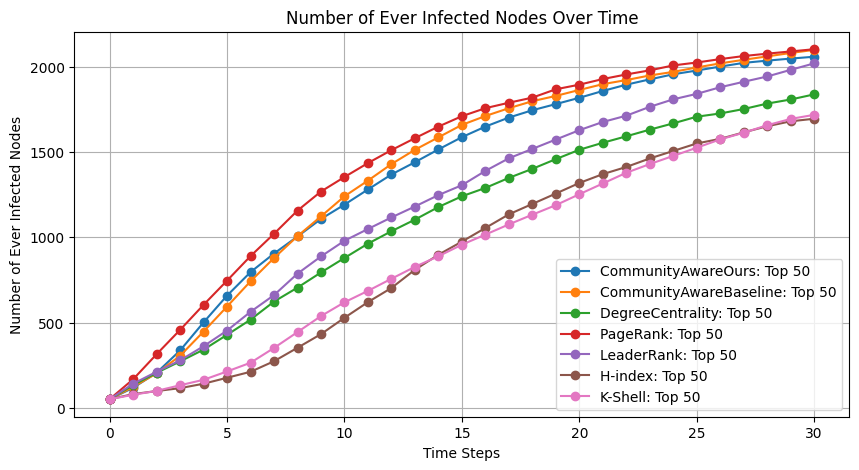

In [30]:
def plot_sir_simulation(G, sorted_maps, top, infection_prob=0.05, steps=100):
    plt.figure(figsize=(10, 5))

    avg_in_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    print(avg_in_degree)
    recovery_prob = 1 / avg_in_degree

    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]
        history, ever_infected, infected_counts = SIR_simulation(G, top_nodes, infection_prob, recovery_prob, steps)
        plt.plot(infected_counts, marker='o', linestyle='-', label=f'{name}: Top {top}')

    plt.title('Number of Ever Infected Nodes Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Ever Infected Nodes')
    plt.grid(True)
    plt.legend()
    plt.show()

def SIR_simulation(G, initial_infected, infection_prob=0.1, recovery_prob=0.05, steps=100):
    status = {node: 'S' for node in G.nodes()}
    for node in initial_infected:
        status[node] = 'I'

    history = []
    ever_infected = set(initial_infected)
    infected_counts = [len(ever_infected)]

    for _ in range(steps):
        new_status = status.copy()
        for node in G.nodes():
            if status[node] == 'I':
                neighbors = list(G.neighbors(node))

                for neighbor in neighbors:
                    if status[neighbor] == 'S' and random.random() < infection_prob:
                        new_status[neighbor] = 'I'
                        ever_infected.add(neighbor)
                if random.random() < recovery_prob:
                    new_status[node] = 'R'
        history.append(new_status)
        status = new_status
        infected_counts.append(len(ever_infected))

        if not any(s == 'I' for s in status.values()):
            break

    return history, ever_infected, infected_counts

sorted_maps = {
    "CommunityAwareOurs": [(node, degree_centrality[node]) for node in ranked_nodes_ours],
    "CommunityAwareBaseline": [(node, degree_centrality[node]) for node in ranked_nodes_baseline],
    "DegreeCentrality": sorted_centrality,
    "PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
    "H-index": sorted_hIndex,
    "K-Shell": sorted_kShell
}

plot_sir_simulation(G, sorted_maps, top=50, infection_prob=0.05, steps=30)